From the [Australian Bureau of Statistics](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/main-structure-and-greater-capital-city-statistical-areas/statistical-area-level-1):

Statistical Areas Level 1 (SA1s) are geographic areas built from whole Mesh Blocks. Whole SA1s aggregate to form Statistical Areas Level 2 (SA2s). SA1s are designed to maximise the geographic detail available for Census of Population and Housing data. However, limited Census of Population and Housing data may also be available at the Mesh Block level for ASGS Edition 3.

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

filepath = os.path.abspath('')
utilpath = f'{filepath}/../util/'
sys.path.append(utilpath)
data_dir = f'{filepath}/../data'

melb_data = pd.read_hdf(f'{data_dir}/melb_data_price_categories.h5')
# melb_data = pd.read_hdf(f'{data_dir}/melb_data.h5')

from melbourne import Melbourne

melbourne = Melbourne(melb_data, frac=1)

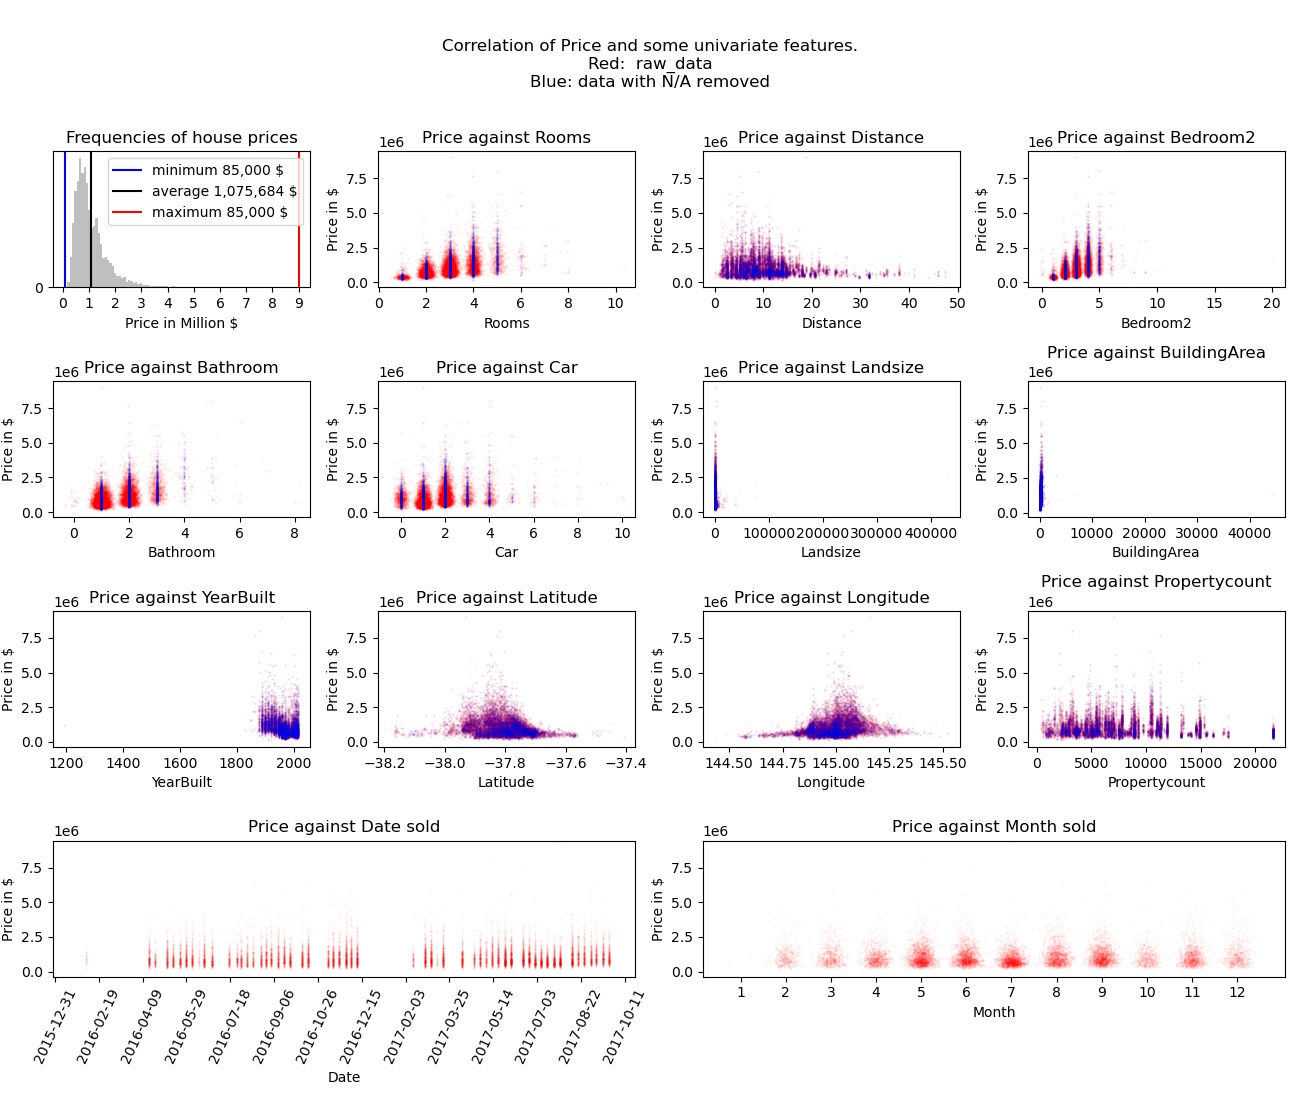

In [2]:
%matplotlib widget

from matplotlib.ticker import MultipleLocator, AutoLocator, FuncFormatter, FixedLocator

jitter = lambda scale=.15, size=len(melbourne.raw_df): np.random.normal(loc=0, scale=scale, size=size)

fig, axes = plt.subplots(4, 4, figsize=(13, 11))
gs = fig.add_gridspec(4, 4)

fig.suptitle('''
Correlation of Price and some univariate features.
Red:  raw_data
Blue: data with N/A removed
''')

ax = axes[0,0]
ax.set_title('Frequencies of house prices')
ax.set_xlabel('Price in Million \\$')
ax.xaxis.set_major_locator(MultipleLocator(base=1e6))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:,.0f}'))
ax.yaxis.set_major_locator(MultipleLocator(base=2e3))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

ax.hist(melbourne.prices, bins=100, range=(melbourne.min_price, melbourne.max_price), color='grey', alpha=.5)
ax.axvline(melbourne.min_price, color='blue', label=f'minimum {melbourne.min_price:,.0f} \\$')
ax.axvline(melbourne.mean_price, color='black', label=f'average {melbourne.mean_price:,.0f} \\$')
ax.axvline(melbourne.max_price, color='red', label=f'maximum {melbourne.min_price:,.0f} \\$')

ax.legend()


# Plot Price against predictor for each of the 11 numerical predictors

for ax, predictor in zip(axes.flatten()[1:], melbourne.numerical_features):
    ax.set(
        title=f'Price against {predictor}',
        xlabel=f'{predictor}',
        ylabel=f'Price in \\$'
    )
    if melbourne.raw_df.dtypes[predictor] == int or predictor in ['Car', 'YearBuilt']:
        ax.scatter(melbourne.raw_df[predictor] + jitter(), melbourne.raw_df['Price'], s=.5, alpha=.05, color='red')
    else:
        ax.scatter(melbourne.raw_df[predictor], melbourne.raw_df['Price'], s=.5, alpha=.05, color='red')
    ax.scatter(melbourne.df[predictor], melbourne.df['Price'], s=.5, alpha=.05, color='blue')


# Plot Price against time features

# Date

ax = fig.add_subplot(gs[3, :2])
axes.flatten()[ len(melbourne.numerical_features) + 1 ]
dates = melbourne.raw_df.loc[:, ['Date', 'Price']].sort_values('Date')
ax.set(
    title=f'Price against Date sold',
    xlabel=f'Date',
    ylabel=f'Price in \\$',
)
ax.scatter(dates['Date'], dates['Price'], s=.25, alpha=.05, color='red')

ax.xaxis.set_major_locator(MultipleLocator(base=50))
ax.tick_params(axis='x', rotation=65)

# Month

ax = ax = fig.add_subplot(gs[3, 2:])
ax.set(
    title=f'Price against Month sold',
    xlabel=f'Month',
    ylabel=f'Price in \\$',
)
ax.scatter(melbourne.raw_df['Month'] + jitter(), melbourne.raw_df['Price'], s=.25, alpha=.05, color='red')

ax.xaxis.set_major_locator(FixedLocator(range(1, 13)))

for ax in axes.flatten()[ len(melbourne.numerical_features) + 1: ]:
    ax.set_visible(False)

fig.tight_layout()
plt.show()

It seems there are outliers or features that clearly sort out samples exceeding or falling below a certain threshold.

In the latter case, we may configure a DecisionTreeRegressor first splitting at these feature thresholds, 
before moving on to automatic max-information-gain splitting.

In [3]:
# Outlier: There is one house with 20 bedrooms.
melbourne.raw_df.loc[melbourne.raw_df.Bedroom2 > 10]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,Propertycount,Month,PriceCategory
7404,Caulfield East,5 Grange Rd,3,h,1650000.0,PI,Woodards,2016-08-06,9.3,3145.0,...,875.0,NaN,NaN,Glen Eira,-37.8815,145.0491,Southern Metropolitan,608,8,8


In [4]:
# Train DecisionTreeRegressor model splitting the feature Landsize at 2500
melbourne.raw_df.loc[melbourne.raw_df.Landsize > 2500].describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Latitude,Longitude,Propertycount,Month,PriceCategory
count,166.000000,1.660000e+02,166.000000,166.000000,166.000000,166.000000,163.000000,166.000000,79.000000,102.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,2.379518,8.049714e+05,7.763253,3109.795181,2.373494,1.566265,1.453988,10417.277108,703.772658,1993.725490,-37.807905,144.981826,8092.301205,6.307229,2.963855
std,1.000274,4.678482e+05,8.999281,109.819274,1.005570,0.645596,0.876317,34675.165364,5007.824948,31.545396,0.076260,0.114094,4490.022561,2.578855,2.716708
min,1.000000,2.800000e+05,0.700000,3000.000000,1.000000,1.000000,0.000000,2522.000000,4.000000,1830.000000,-38.182550,144.485710,249.000000,2.000000,0.000000
25%,2.000000,5.027500e+05,2.725000,3033.000000,2.000000,1.000000,1.000000,3201.500000,70.000000,1995.000000,-37.836130,144.938367,4918.000000,4.000000,1.000000
50%,2.000000,6.550000e+05,4.500000,3101.500000,2.000000,1.000000,1.000000,4314.000000,81.000000,2005.000000,-37.808980,144.983615,6786.000000,6.000000,2.000000
75%,3.000000,9.442500e+05,8.700000,3141.000000,3.000000,2.000000,2.000000,7167.250000,116.000000,2011.000000,-37.784600,145.010400,11308.000000,8.000000,5.000000
max,7.000000,2.705000e+06,48.100000,3795.000000,7.000000,4.000000,5.000000,433014.000000,44515.000000,2015.000000,-37.453920,145.470520,21650.000000,12.000000,9.000000


In [5]:
# Train DecisionTreeRegressor model splitting the feature BuildingArea at 500
melbourne.raw_df.loc[melbourne.raw_df.BuildingArea > 500].describe()
# melbourne.df.sort_values('BuildingArea')

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Latitude,Longitude,Propertycount,Month,PriceCategory
count,63.000000,6.300000e+01,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,43.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,3.825397,1.554294e+06,12.996825,3127.666667,3.730159,2.206349,2.190476,1377.301587,1531.597090,1968.116279,-37.827244,145.028788,8132.793651,7.047619,6.095238
std,1.198651,9.967659e+05,8.245859,112.152834,1.152925,1.333909,1.075492,5535.463141,5578.485582,32.156766,0.104698,0.127571,4790.034915,2.260663,2.739875
min,2.000000,4.350000e+05,3.500000,3012.000000,2.000000,1.000000,0.000000,0.000000,501.000000,1890.000000,-38.104600,144.588640,849.000000,2.000000,0.000000
25%,3.000000,8.750000e+05,9.050000,3072.000000,3.000000,1.000000,2.000000,532.000000,530.500000,1950.000000,-37.892750,144.986350,4794.000000,6.000000,4.000000
50%,4.000000,1.241000e+06,11.100000,3105.000000,4.000000,2.000000,2.000000,625.000000,613.000000,1965.000000,-37.824800,145.035400,7485.000000,7.000000,7.000000
75%,4.500000,1.911500e+06,13.850000,3164.000000,4.000000,3.000000,2.000000,731.000000,719.500000,1999.500000,-37.761900,145.087800,10412.000000,9.000000,9.000000
max,8.000000,5.525000e+06,48.100000,3810.000000,9.000000,7.000000,6.000000,44500.000000,44515.000000,2013.000000,-37.453920,145.482730,21650.000000,12.000000,9.000000


In [6]:
# one building was built before 1800. This is clearly an outlier. Maybe its also a wrong input ...?
# Do not train DecisionTreeRegressor model by splitting on feature YearBuilt at 1800.
# This would clearly lead to wrong price predictions for all buildings built before 1800 because the
# training set consists of just the following single example:
melbourne.raw_df.loc[melbourne.raw_df.YearBuilt < 1800]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,Propertycount,Month,PriceCategory
9968,Mount Waverley,5 Armstrong St,3,h,1200000.0,VB,McGrath,2017-06-24,14.2,3149.0,...,807.0,117.0,1196.0,Monash,-37.86788,145.12121,Eastern Metropolitan,13366,6,7


In [7]:
melbourne.raw_df.loc[melbourne.raw_df.Propertycount > 20000].describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Latitude,Longitude,Propertycount,Month,PriceCategory
count,359.000000,3.590000e+02,359.000000,359.0,359.000000,359.000000,359.000000,359.000000,174.000000,203.000000,359.000000,359.000000,359.0,359.000000,359.000000
mean,2.810585,6.900089e+05,11.420613,3073.0,2.777159,1.284123,1.849582,584.278552,124.555345,1975.073892,-37.713984,145.009586,21650.0,7.272981,2.512535
std,0.820682,2.313681e+05,0.358019,0.0,0.815651,0.515187,1.123489,2189.728660,79.619236,26.539145,0.010203,0.013639,0.0,2.632653,1.958860
min,1.000000,2.160000e+05,11.200000,3073.0,0.000000,1.000000,0.000000,0.000000,1.000000,1920.000000,-37.732800,144.975500,21650.0,2.000000,0.000000
25%,2.000000,5.022500e+05,11.200000,3073.0,2.000000,1.000000,1.000000,183.500000,84.250000,1960.000000,-37.722750,144.998960,21650.0,5.000000,1.000000
50%,3.000000,6.850000e+05,11.200000,3073.0,3.000000,1.000000,2.000000,513.000000,108.500000,1970.000000,-37.713310,145.010390,21650.0,7.000000,2.000000
75%,3.000000,8.425000e+05,12.000000,3073.0,3.000000,2.000000,2.000000,656.500000,135.750000,2006.000000,-37.706430,145.021000,21650.0,9.000000,4.000000
max,5.000000,1.700000e+06,12.000000,3073.0,5.000000,3.000000,10.000000,41400.000000,558.000000,2017.000000,-37.691700,145.036100,21650.0,12.000000,8.000000


In [8]:
# Some super expensive houses. Should they be treated as outliers?
melbourne.raw_df.loc[melbourne.raw_df.Price > 5e6]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,Regionname,Propertycount,Month,PriceCategory
9575,Hawthorn,49 Lisson Gr,4,h,7650000.0,S,Abercromby's,2017-06-17,5.3,3122.0,...,1690.0,284.0,1863.0,Boroondara,-37.82652,145.03052,Southern Metropolitan,11308,6,9
5631,South Yarra,18 Avoca St,4,h,5700000.0,S,Castran,2016-11-12,3.3,3141.0,...,292.0,272.0,1880.0,Stonnington,-37.83770,144.98940,Southern Metropolitan,14887,11,9
12094,Mulgrave,35 Bevis St,3,h,9000000.0,PI,Hall,2017-07-29,18.8,3170.0,...,744.0,117.0,1960.0,Monash,-37.93168,145.16126,South-Eastern Metropolitan,7113,7,9
3616,Kew,15 Barry St,6,h,6500000.0,S,Jellis,2016-08-13,5.6,3101.0,...,1334.0,365.0,1890.0,Boroondara,-37.80290,145.02670,Southern Metropolitan,10331,8,9
12239,Brighton,139 Cole St,5,h,5500000.0,VB,Marshall,2017-09-03,10.5,3186.0,...,830.0,NaN,NaN,NaN,-37.89544,145.00279,Southern Metropolitan,10579,9,9
7692,Canterbury,49 Mangarra Rd,5,h,8000000.0,VB,Sotheby's,2017-05-13,9.0,3126.0,...,2079.0,464.3,1880.0,Boroondara,-37.81790,145.06940,Southern Metropolitan,3265,5,9
251,Armadale,367 Dandenong Rd,6,h,5525000.0,S,Marshall,2016-09-17,6.3,3143.0,...,1491.0,516.0,1935.0,Stonnington,-37.86020,145.01300,Southern Metropolitan,4836,9,9
6340,Toorak,10 Myoora Rd,4,h,5500000.0,VB,Marshall,2016-12-03,4.6,3142.0,...,691.0,374.0,2000.0,Stonnington,-37.84310,145.02100,Southern Metropolitan,7217,12,9
5801,St Kilda,18 Crimea St,5,h,5046000.0,S,Abercromby's,2016-12-10,6.1,3182.0,...,1294.0,378.0,1884.0,Port Phillip,-37.85890,144.98830,Southern Metropolitan,13240,12,9
8725,Armadale,52 Adelaide St,5,h,5200000.0,SP,Marshall,2017-07-01,6.3,3143.0,...,761.0,NaN,NaN,Stonnington,-37.85311,145.02847,Southern Metropolitan,4836,7,9


In [9]:
melbourne.raw_df['YearBuilt'].isna()

10720    False
10771    False
5603     False
2395      True
11449     True
         ...  
2049     False
12561    False
2638      True
10925     True
260       True
Name: YearBuilt, Length: 13580, dtype: bool

In [10]:
outliers_above = {
    'Bedroom2': 10,
    'Landsize': 2500,
    'BuildingArea': 500,
    'Propertycount': 20000
}
outliers_below = {
    'YearBuilt': 1800,
}

from functools import reduce
from numpy import logical_and

#############################################################################################
##
##  Exclude features on `pd.NA` entries
##  `pd.NA <= threshold` and `pd.NA >= threshold` turn out to be `False`
##  -> only 6571 entries remain
##
#############################################################################################

# mask_list_raw = [
#     melbourne.raw_df[feature] <= threshold for feature, threshold in outliers_above.items()
# ] + [
#     melbourne.raw_df[feature] >= threshold for feature, threshold in outliers_below.items()
# ]

#############################################################################################
##
##  Include features with `pd.NA` entries
##  The following hack is equivalent to the above if `melbourne.raw_df[feature]` is not `pd.NA`
##  However, if `melbourne.raw_df[feature]` is `pd.NA`, we get `~False` which is `True`
##  -> 12997 entries remain
##
#############################################################################################

mask_list_raw = [
    ~(melbourne.raw_df[feature] > threshold) for feature, threshold in outliers_above.items()
] + [
    ~(melbourne.raw_df[feature] < threshold) for feature, threshold in outliers_below.items()
]

mask_raw = reduce(logical_and, mask_list_raw)
melbourne_outliers_removed_raw = melbourne.raw_df[mask_raw]

# write to disk
melbourne_outliers_removed_raw.to_csv(f'{data_dir}/melb_data_outliers_removed.csv')
melbourne_outliers_removed_raw.to_hdf(f'{data_dir}/melb_data_outliers_removed.h5', key='melb_data_outliers_removed', mode='w')

melbourne_outliers_removed_raw.describe()

/var/folders/7f/gh6c5k2j1lb85_805l_29r580000gn/T/ipykernel_64685/1134618354.py:48: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'CouncilArea',
       'Regionname'],
      dtype='object')]

  melbourne_outliers_removed_raw.to_hdf(f'{data_dir}/melb_data_outliers_removed.h5', key='melb_data_outliers_removed', mode='w')


,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Latitude,Longitude,Propertycount,Month,PriceCategory
count,12997.000000,1.299700e+04,12997.000000,12997.000000,12997.000000,12997.000000,12938.000000,12997.000000,6819.000000,7859.000000,12997.000000,12997.000000,12997.000000,12997.000000,12997.000000
mean,2.944526,1.087310e+06,10.121382,3106.032238,2.920366,1.537663,1.602953,434.778103,140.714776,1964.118717,-37.811686,144.994786,7055.806648,7.056475,4.614834
std,0.953158,6.417099e+05,5.881061,91.404353,0.952818,0.689410,0.957203,338.533437,71.859022,36.397620,0.078673,0.105036,3742.775661,2.532895,2.912649
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1850.000000,-38.168020,144.431810,389.000000,1.000000,0.000000
25%,2.000000,6.525000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,173.000000,94.000000,1940.000000,-37.858100,144.926630,4217.000000,5.000000,2.000000
50%,3.000000,9.180000e+05,9.200000,3088.000000,3.000000,1.000000,2.000000,422.000000,126.000000,1970.000000,-37.805200,144.999400,6482.000000,7.000000,5.000000
75%,4.000000,1.350000e+06,13.000000,3150.000000,3.000000,2.000000,2.000000,648.000000,173.000000,1998.000000,-37.760000,145.060300,9264.000000,9.000000,7.000000
max,10.000000,9.000000e+06,47.400000,3977.000000,10.000000,8.000000,10.000000,2488.000000,500.000000,2018.000000,-37.408530,145.526350,17496.000000,12.000000,9.000000


In [11]:
# We do not need to make this hack on `melbourne.df` because `melbourne.df` has `pd.NA` removed anyway!

mask_list = [
    melbourne.df[feature] <= threshold for feature, threshold in outliers_above.items()
] + [
    melbourne.df[feature] >= threshold for feature, threshold in outliers_below.items()
]

mask = reduce(logical_and, mask_list)
melbourne_outliers_removed = melbourne.df[mask]

melbourne_outliers_removed.describe()

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Latitude,Longitude,Propertycount,Price
count,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6.544000e+03
mean,2.986400,10.149679,2.959658,1.598105,1.601925,421.361247,140.886408,1963.918857,-37.810278,144.991411,7053.997402,1.089197e+06
std,0.964587,6.039318,0.966926,0.710074,0.937772,332.246023,70.590105,36.658421,0.079771,0.106317,3748.862276,6.735183e+05
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1850.000000,-38.164920,144.542370,389.000000,1.310000e+05
25%,2.000000,6.100000,2.000000,1.000000,1.000000,164.000000,94.000000,1940.000000,-37.858025,144.923533,4217.000000,6.400000e+05
50%,3.000000,9.200000,3.000000,1.000000,2.000000,397.500000,127.000000,1970.000000,-37.804600,144.995800,6543.000000,9.000000e+05
75%,4.000000,13.000000,4.000000,2.000000,2.000000,632.250000,173.000000,1999.000000,-37.759700,145.058225,9264.000000,1.350000e+06
max,8.000000,47.400000,9.000000,8.000000,10.000000,2488.000000,495.000000,2018.000000,-37.408530,145.526350,17496.000000,9.000000e+06


We make the same plots as before, but this time without the outliers

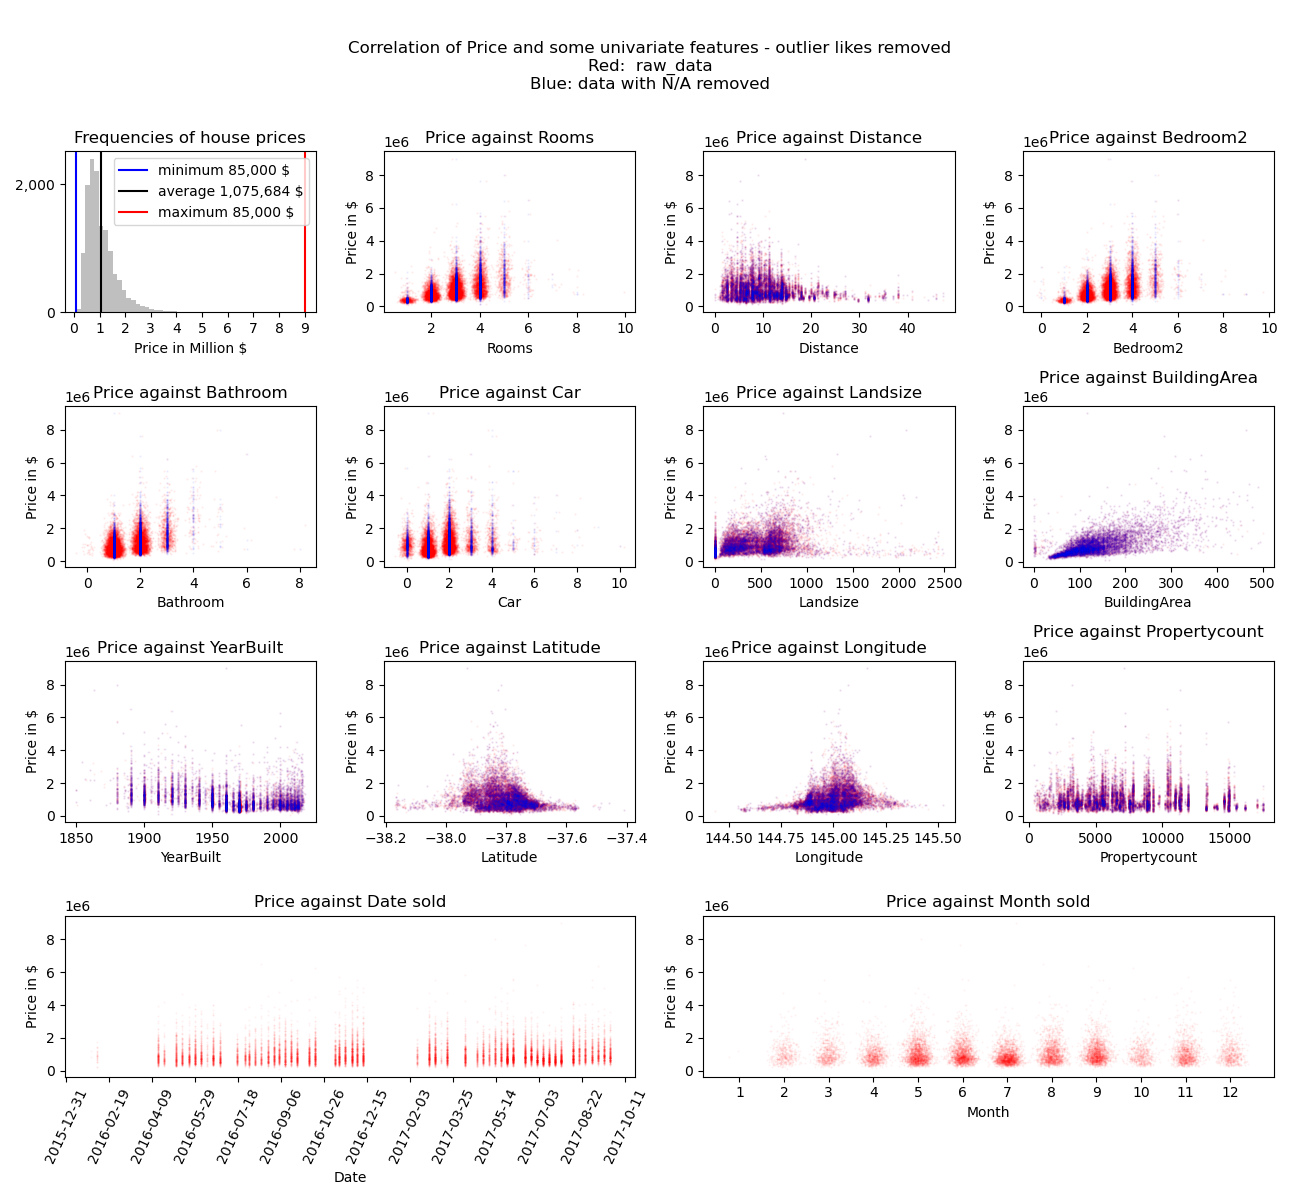

In [12]:
fig, axes = plt.subplots(4, 4, figsize=(13, 12))

fig.suptitle('''
Correlation of Price and some univariate features - outlier likes removed
Red:  raw_data
Blue: data with N/A removed
''')

ax = axes[0,0]
ax.set_title('Frequencies of house prices')
ax.set_xlabel('Price in Million \\$')
ax.xaxis.set_major_locator(MultipleLocator(base=1e6))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:,.0f}'))
ax.yaxis.set_major_locator(MultipleLocator(base=2e3))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

ax.hist(melbourne.prices, bins=50, range=(melbourne.min_price, melbourne.max_price), color='grey', alpha=.5)
ax.axvline(melbourne.min_price, color='blue', label=f'minimum {melbourne.min_price:,.0f} \\$')
ax.axvline(melbourne.mean_price, color='black', label=f'average {melbourne.mean_price:,.0f} \\$')
ax.axvline(melbourne.max_price, color='red', label=f'maximum {melbourne.min_price:,.0f} \\$')

ax.legend()

# Plot Price against predictor for each of the 11 numerical predictors

for ax, predictor in zip(axes.flatten()[1:], melbourne.numerical_features):
    ax.set(
        title=f'Price against {predictor}',
        xlabel=f'{predictor}',
        ylabel=f'Price in \\$'
    )
    if melbourne.raw_df.dtypes[predictor] == int or predictor in ['Car', 'YearBuilt']:
        ax.scatter(melbourne_outliers_removed_raw[predictor] + jitter(size=len(melbourne_outliers_removed_raw)), melbourne_outliers_removed_raw['Price'], s=.5, alpha=.05, color='red')
    else:
        ax.scatter(melbourne_outliers_removed_raw[predictor], melbourne_outliers_removed_raw['Price'], s=.5, alpha=.05, color='red')
    ax.scatter(melbourne_outliers_removed[predictor], melbourne_outliers_removed['Price'], s=.5, alpha=.05, color='blue')


# Plot Price against time features

# Date

ax = fig.add_subplot(gs[3, :2])
axes.flatten()[ len(melbourne.numerical_features) + 1 ]
dates = melbourne.raw_df.loc[:, ['Date', 'Price']].sort_values('Date')
ax.set(
    title=f'Price against Date sold',
    xlabel=f'Date',
    ylabel=f'Price in \\$',
)
ax.scatter(dates['Date'], dates['Price'], s=.25, alpha=.05, color='red')

ax.xaxis.set_major_locator(MultipleLocator(base=50))
ax.tick_params(axis='x', rotation=65)

# Month

ax = ax = fig.add_subplot(gs[3, 2:])
ax.set(
    title=f'Price against Month sold',
    xlabel=f'Month',
    ylabel=f'Price in \\$',
)
ax.scatter(melbourne.raw_df['Month'] + jitter(), melbourne.raw_df['Price'], s=.25, alpha=.05, color='red')

ax.xaxis.set_major_locator(FixedLocator(range(1, 13)))

for ax in axes.flatten()[ len(melbourne.numerical_features) + 1: ]:
    ax.set_visible(False)


fig.tight_layout()
plt.show()

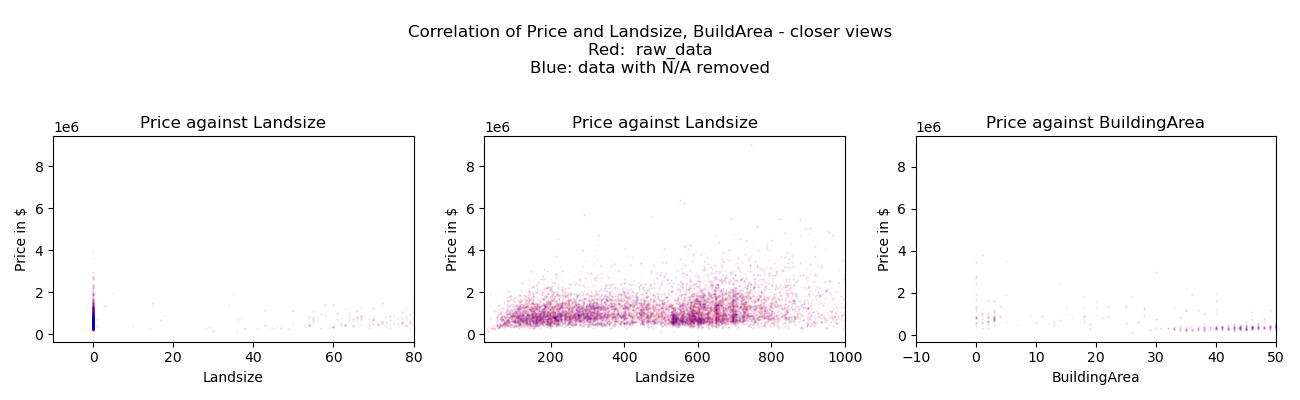

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

fig.suptitle('''
Correlation of Price and Landsize, BuildArea - closer views
Red:  raw_data
Blue: data with N/A removed
''')

xranges = [
    (-10, 80),
    (20, 1000),
    (-10, 50)
]

for ax, predictor, xrange in zip(axes, ['Landsize', 'Landsize', 'BuildingArea'], xranges):
    ax.set(
        title=f'Price against {predictor}',
        xlabel=f'{predictor}',
        ylabel=f'Price in \\$',
        xlim=xrange
    )
    ax.scatter(melbourne_outliers_removed_raw[predictor], melbourne_outliers_removed_raw['Price'], s=.5, alpha=.05, color='red')
    ax.scatter(melbourne_outliers_removed[predictor], melbourne_outliers_removed['Price'], s=.5, alpha=.05, color='blue')

fig.tight_layout()
plt.show()

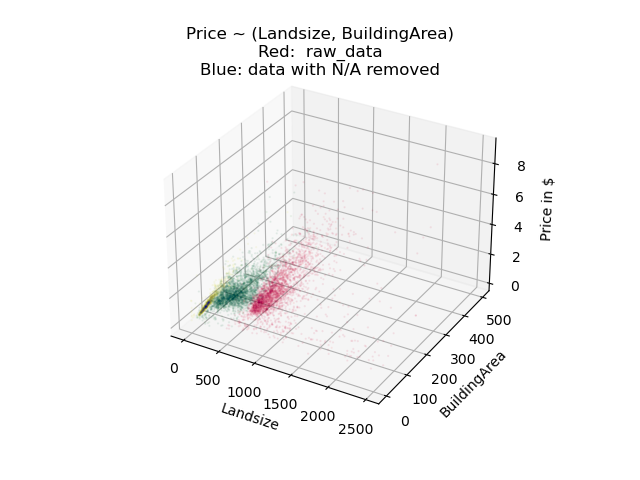

In [14]:
%matplotlib widget
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.suptitle('''
Price ~ (Landsize, BuildingArea)
Red:  raw_data
Blue: data with N/A removed
''')

melbourne_outliers_removed_raw_0 = melbourne_outliers_removed_raw[ melbourne_outliers_removed_raw.Landsize == 0 ]
melbourne_outliers_removed_raw_1 = melbourne_outliers_removed_raw[ (melbourne_outliers_removed_raw.Landsize > 0) & (melbourne_outliers_removed_raw.Landsize < 500) ]
melbourne_outliers_removed_raw_2 = melbourne_outliers_removed_raw[ melbourne_outliers_removed_raw.Landsize >= 500 ]

ax.set(
    xlabel='Landsize',
    ylabel='BuildingArea',
    zlabel=f'Price in \\$',
)
ax.scatter(melbourne_outliers_removed_raw_0.Landsize, melbourne_outliers_removed_raw_0.BuildingArea, melbourne_outliers_removed_raw_0.Price, s=.5, alpha=.05, color='yellow')
ax.scatter(melbourne_outliers_removed_raw_1.Landsize, melbourne_outliers_removed_raw_1.BuildingArea, melbourne_outliers_removed_raw_1.Price, s=.5, alpha=.05, color='green')
ax.scatter(melbourne_outliers_removed_raw_2.Landsize, melbourne_outliers_removed_raw_2.BuildingArea, melbourne_outliers_removed_raw_2.Price, s=.5, alpha=.05, color='red')
ax.scatter(melbourne_outliers_removed.Landsize, melbourne_outliers_removed.BuildingArea, melbourne_outliers_removed.Price, s=.5, alpha=.01, color='blue')

plt.show()

The 3d plot `Price` against `(Landsize, BuildingArea)` clearly shows that `Landsize == 0` is __not__ marking outliers.
`Landsize` and `BuildingArea` are rather __correlated__.

Furthermore, there seem to be three data clusters separable by the feature `Landsize` by
* `Landsize == 0`
* `Landsize in (0, 500)`
* `Landsize > 500`

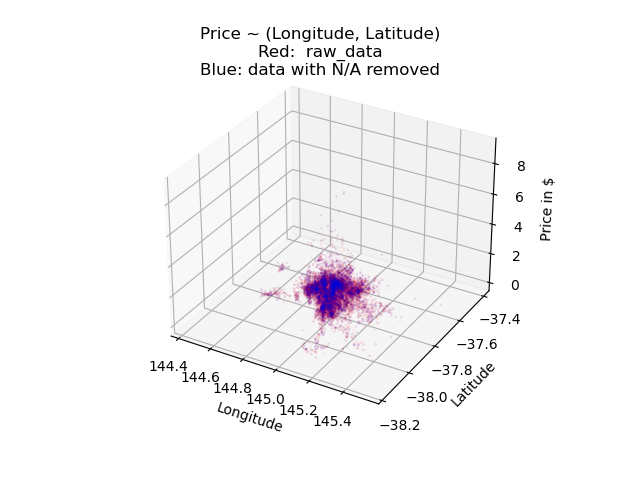

In [15]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.suptitle('''
Price ~ (Longitude, Latitude)
Red:  raw_data
Blue: data with N/A removed
''')

ax.set(
    xlabel='Longitude',
    ylabel='Latitude',
    zlabel=f'Price in \\$',
)
ax.scatter(melbourne_outliers_removed_raw.Longitude, melbourne_outliers_removed_raw.Latitude, melbourne_outliers_removed_raw.Price, s=.5, alpha=.05, color='red')
ax.scatter(melbourne_outliers_removed.Longitude, melbourne_outliers_removed.Latitude, melbourne_outliers_removed.Price, s=.5, alpha=.05, color='blue')

plt.show()

In [16]:
melbourne_outliers_removed_raw.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Latitude,Longitude,Propertycount,Month,PriceCategory
count,12997.000000,1.299700e+04,12997.000000,12997.000000,12997.000000,12997.000000,12938.000000,12997.000000,6819.000000,7859.000000,12997.000000,12997.000000,12997.000000,12997.000000,12997.000000
mean,2.944526,1.087310e+06,10.121382,3106.032238,2.920366,1.537663,1.602953,434.778103,140.714776,1964.118717,-37.811686,144.994786,7055.806648,7.056475,4.614834
std,0.953158,6.417099e+05,5.881061,91.404353,0.952818,0.689410,0.957203,338.533437,71.859022,36.397620,0.078673,0.105036,3742.775661,2.532895,2.912649
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1850.000000,-38.168020,144.431810,389.000000,1.000000,0.000000
25%,2.000000,6.525000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,173.000000,94.000000,1940.000000,-37.858100,144.926630,4217.000000,5.000000,2.000000
50%,3.000000,9.180000e+05,9.200000,3088.000000,3.000000,1.000000,2.000000,422.000000,126.000000,1970.000000,-37.805200,144.999400,6482.000000,7.000000,5.000000
75%,4.000000,1.350000e+06,13.000000,3150.000000,3.000000,2.000000,2.000000,648.000000,173.000000,1998.000000,-37.760000,145.060300,9264.000000,9.000000,7.000000
max,10.000000,9.000000e+06,47.400000,3977.000000,10.000000,8.000000,10.000000,2488.000000,500.000000,2018.000000,-37.408530,145.526350,17496.000000,12.000000,9.000000
